# Titanic Survival Classification
Based on the notebooks by:  
[Alexis Cook](http://www.kaggle.com/alexisbcook/titanic-tutorial)  
[Francisco Javier Gallego](https://www.kaggle.com/javigallego/top-5-hyperparameter-tuning-ensemble-modeling?scriptVersionId=88795500)  
[Woo Seung Han](https://www.kaggle.com/hadeux/titanic-survivor-predict-eda-lightgbm-kor-eng/notebook)  

In [1]:
# autocomplete ON
%config Completer.use_jedi = False

In [2]:
# Load libraries
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt

## <b> 1 <span style='color:#ffb2ae'> | </span> Data prep & EDA </b>

<div style='color: white; display: fill; 
    border-radius: 8px; background-color: #ffb2ae;
    font-size: 100%; letter-spacing:0.5px'> 
    <p style='padding: 8px; color: black;'> 
        <b>1.1 &nbsp; Load data </b>
    </p>
</div> 

In [3]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [4]:
# Load train and test data
df_train = pd.read_csv('../input/titanic/train.csv')
df_test = pd.read_csv('../input/titanic/test.csv')
gender_submission = pd.read_csv('../input/titanic/gender_submission.csv')

# Concatenate two data sets
df_data = pd.concat([df_train, df_test], sort=True).reset_index(drop=True)

<div style='color: white; display: fill; 
    border-radius: 8px; background-color: #ffb2ae;
    font-size: 100%; letter-spacing:0.5px'> 
    <p style='padding: 8px; color: black;'> 
        <b>1.2 &nbsp; EDA </b>
    </p>
</div> 

In [5]:
## Visually inspect first few rows of each table
df_train.head(3)
# df_test.head(3)
# gender_submission.head(3)

### Task is to predict "Survived" for each "PassengerId"

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [6]:
## Show table schema
# df_train.info()
# df_test.info()
df_data.info()

### Excluding the Id and independent variable, there are 10 features

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1046 non-null   float64
 1   Cabin        295 non-null    object 
 2   Embarked     1307 non-null   object 
 3   Fare         1308 non-null   float64
 4   Name         1309 non-null   object 
 5   Parch        1309 non-null   int64  
 6   PassengerId  1309 non-null   int64  
 7   Pclass       1309 non-null   int64  
 8   Sex          1309 non-null   object 
 9   SibSp        1309 non-null   int64  
 10  Survived     891 non-null    float64
 11  Ticket       1309 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [7]:
df_data.describe(include='all')

### Seems to be duplicate names and tickets
### Overall survival rate is 38.38%

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
count,1046.000000,295,1307,1308.000000,1309,1309.000000,1309.000000,1309.000000,1309,1309.000000,891.000000,1309
unique,NaN,186,3,NaN,1307,NaN,NaN,NaN,2,NaN,NaN,929
top,NaN,C23 C25 C27,S,NaN,"Connolly, Miss. Kate",NaN,NaN,NaN,male,NaN,NaN,CA. 2343
freq,NaN,6,914,NaN,2,NaN,NaN,NaN,843,NaN,NaN,11
mean,29.881138,NaN,NaN,33.295479,NaN,0.385027,655.000000,2.294882,NaN,0.498854,0.383838,NaN
std,14.413493,NaN,NaN,51.758668,NaN,0.865560,378.020061,0.837836,NaN,1.041658,0.486592,NaN
min,0.170000,NaN,NaN,0.000000,NaN,0.000000,1.000000,1.000000,NaN,0.000000,0.000000,NaN
25%,21.000000,NaN,NaN,7.895800,NaN,0.000000,328.000000,2.000000,NaN,0.000000,0.000000,NaN
50%,28.000000,NaN,NaN,14.454200,NaN,0.000000,655.000000,3.000000,NaN,0.000000,0.000000,NaN
75%,39.000000,NaN,NaN,31.275000,NaN,0.000000,982.000000,3.000000,NaN,1.000000,1.000000,NaN


In [8]:
# Check for any duplicates
df_data.duplicated().value_counts()

### No duplicate rows between training and test datasets

# Check for people with the same names
# df_data.Name.duplicated().value_counts()
# df_train[df_train['Name'].isin(df_data[df_data.Name.duplicated()].Name.tolist())]
# df_test[df_test['Name'].isin(df_data[df_data.Name.duplicated()].Name.tolist())]
df_data[df_data['Name'].isin(df_data[df_data.Name.duplicated()].Name.tolist())]

### There are two pairs of people exactly matching the names Miss Kate Connolly and Mr. Kelly James respectively.
### Upon inspection, people in both pairs have different passenger ID, ticket number, and paid different a different fare amount.
### It should be safe to assume that they are all different people with the same name. 

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
289,22.0,NaN,Q,7.7500,"Connolly, Miss. Kate",0,290,3,female,0,1.0,370373
696,44.0,NaN,S,8.0500,"Kelly, Mr. James",0,697,3,male,0,0.0,363592
891,34.5,NaN,Q,7.8292,"Kelly, Mr. James",0,892,3,male,0,NaN,330911
897,30.0,NaN,Q,7.6292,"Connolly, Miss. Kate",0,898,3,female,0,NaN,330972


In [9]:
## Count missing values from each column
# df_train.isna().sum()
df_test.isna().sum()
# df_data.isna().sum()

### Columns "Age", "Cabin", and "Embarked" have missing values

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [10]:
# Functions for drawing pair plots with annotations

def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)
    
def pairPlot(data, column=None):
    if column:
        num = len(data[column].unique())
        g = sns.PairGrid(data, hue=column, hue_kws=sns.color_palette('vlag', n_colors=2, as_cmap=True), dropna=True)
        g.map_offdiag(sns.scatterplot)
        g.add_legend()
    else:
        g = sns.PairGrid(data, dropna=True)
        g.map_offdiag(corrfunc)
        g.map_offdiag(sns.regplot)
    g.map_diag(sns.histplot)
    return g

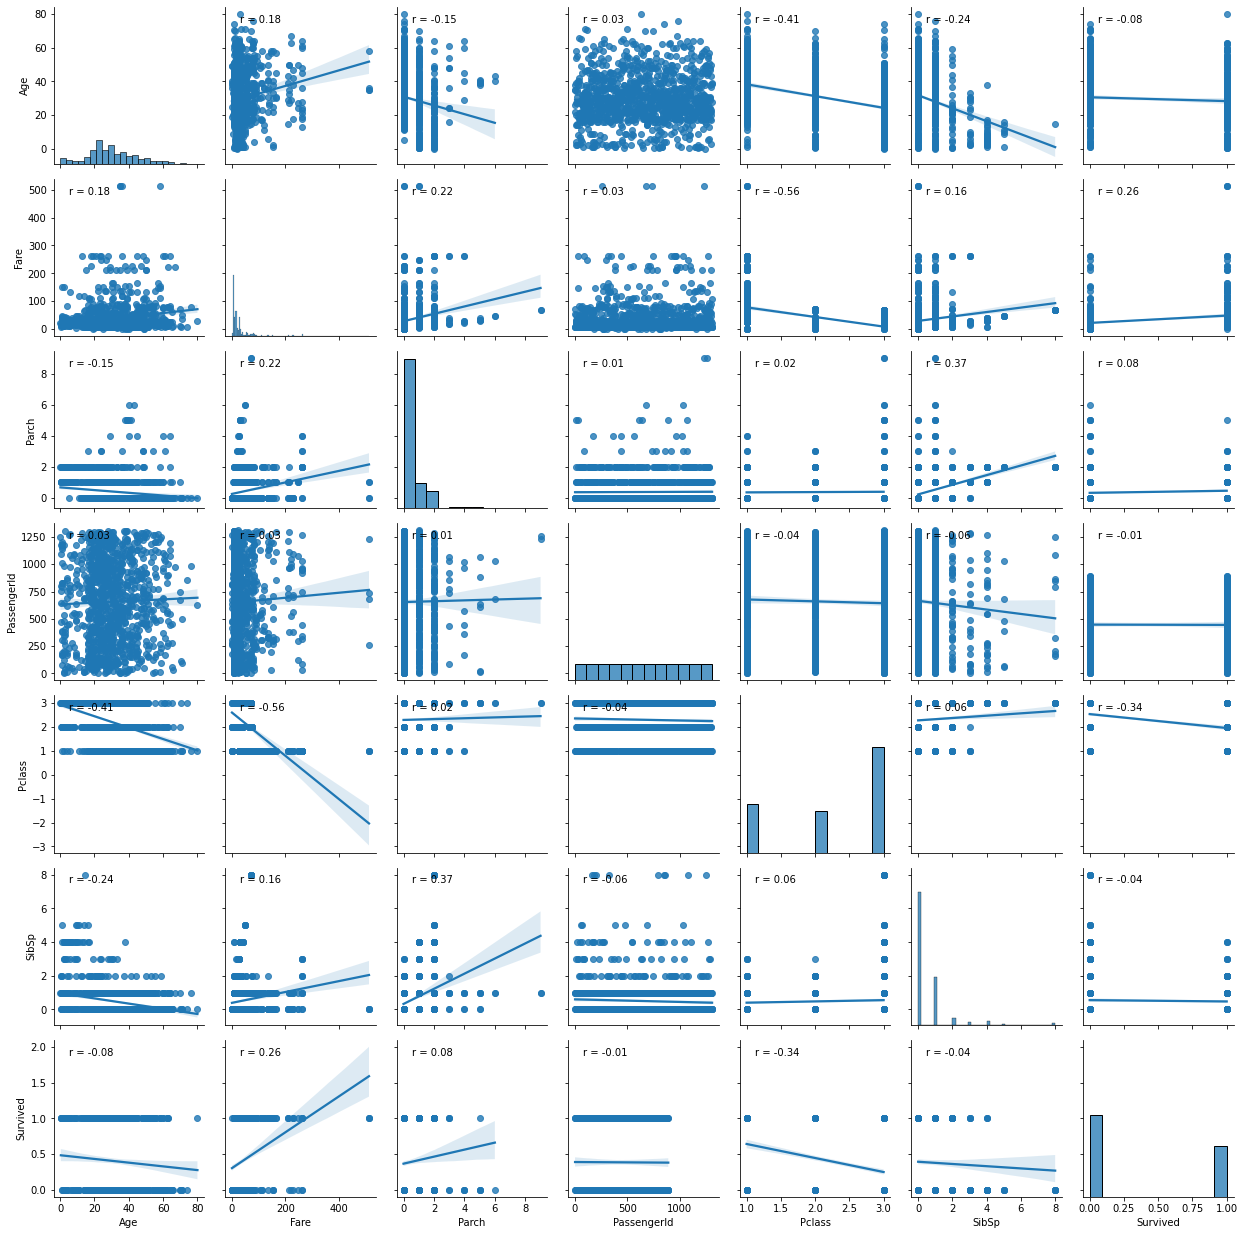

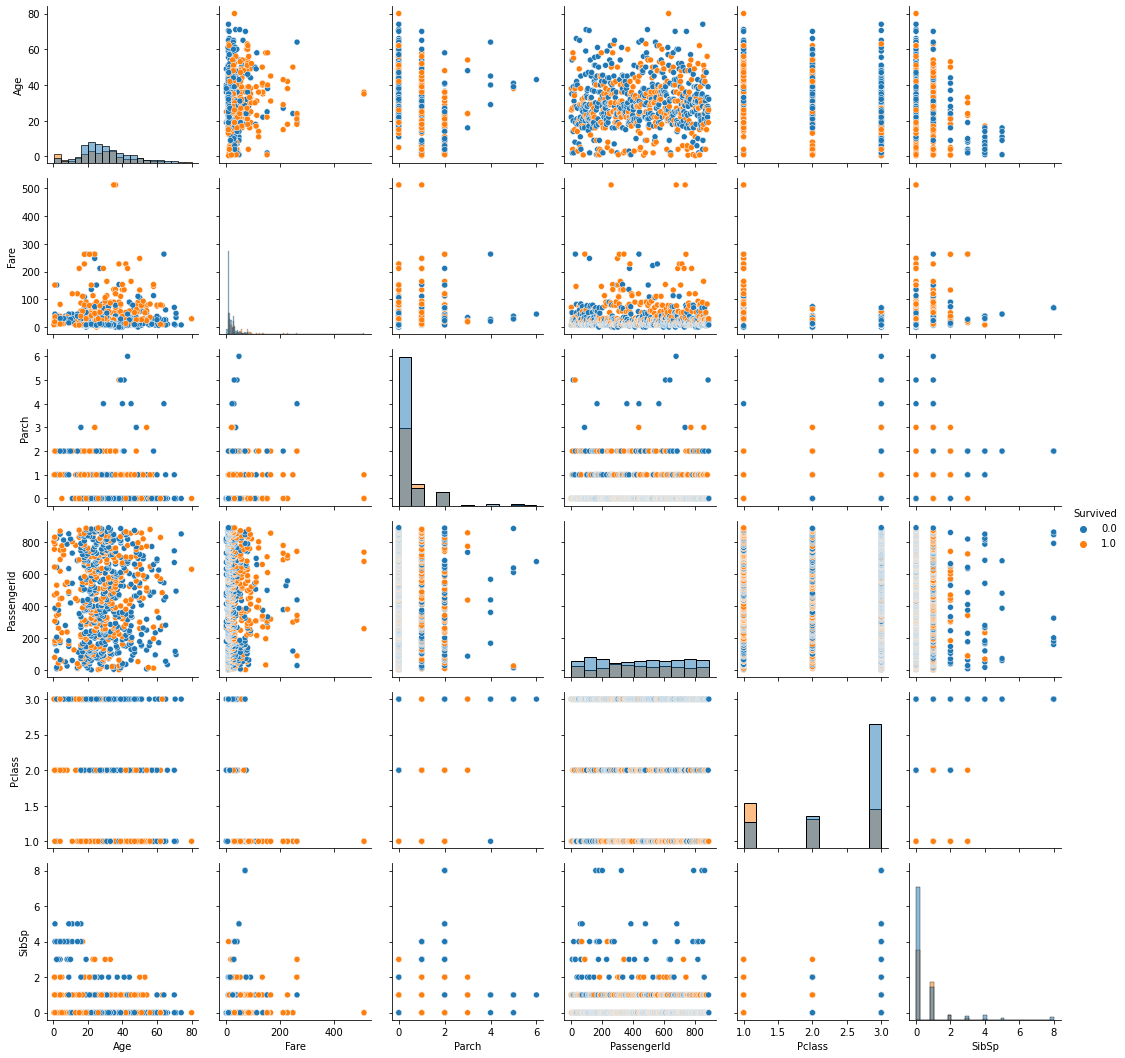

In [11]:
# Visualize pair-wise distribution of numerical features using a pair plot
pairPlot(df_data)
pairPlot(df_data, 'Survived')
# sns.pairplot(data=df_data, kind = 'reg')
# sns.pairplot(data=df_data, kind = 'hist', hue='Survived', palette={0:'blue',1:'green'})

<AxesSubplot:>

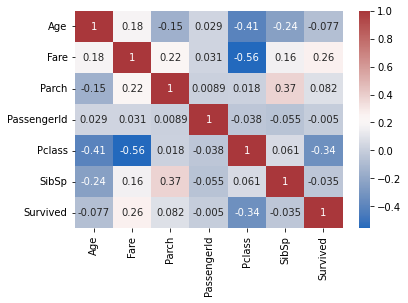

In [12]:
# Heat map to visualize correlation between variables
sns.heatmap(df_data.corr(), annot=True, cmap='vlag')

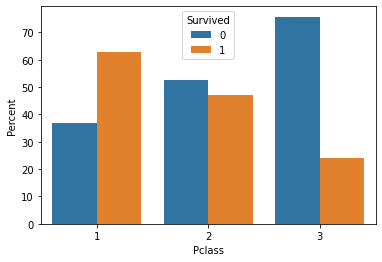

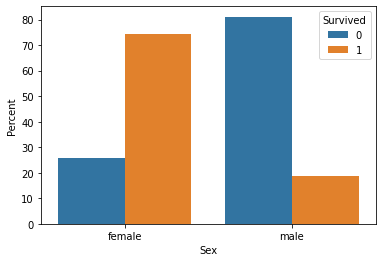

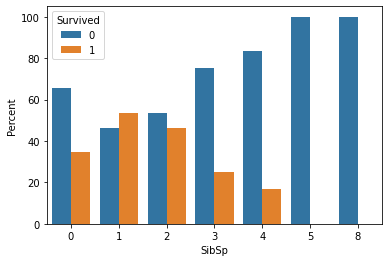

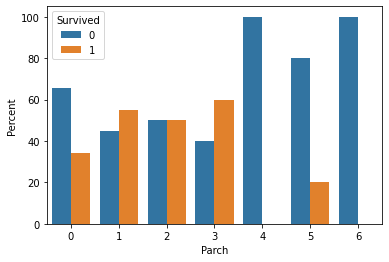

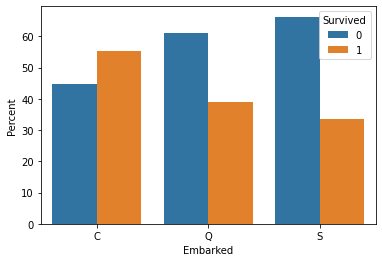

In [13]:
# Tally groups to see which features may be important for survival
# Especially categorical variables not visualized by pair plots above

# df_train.groupby(['Survived', 'Sex']).size()
def categoricalPlots(data, y=None):
    for col in data:
        if col == y:
            continue
        elif (len(data[col].unique())) < 10:
            x=col
            (data
            .groupby(x)[y]
            .value_counts(normalize=True)
            .mul(100)
            .rename('Percent')
            .reset_index()
            .pipe((sns.barplot, 'data'), x=x, y='Percent', hue=y))
            plt.show()
categoricalPlots(df_train, y='Survived')
# sns.countplot(x='Survived', hue='Sex', data = df_train)

#### **EDA KEY INSIGHTS**
1. There is class imbalance in the trainng set (more people died than survived)
2. There were duplicate names between train and test data sets but upon closer inspection, they seem to be different people with the same names. 
3. There are missing values for the following features: "Age", "Cabin", "Embarked", and "Fare". 
4. "Ticket" and "Cabin" are complex string variables that may be important indicator in predicting survival. 
5. Among numerical features, "Fare" is correlated with survival
6. All categorical features seem to be associated with survival, especially "Sex" and "PClass".  

## <b> 2 <span style='color:#ffc967'> | </span> Data processing</b>

<div style='color: white; display: fill; 
    border-radius: 8px; background-color: #ffc967;
    font-size: 100%; letter-spacing:0.5px'> 
    <p style='padding: 8px; color: black;'> 
        <b>2.1 &nbsp; Feature engineering</b>
    </p>
</div> 

#### Title (Honorific)
Some people have titles (ex. Mr. Mrs.) in their names. In addition to biological sex, their titles can signify positions of power and authority (ex. Capt, Countess, Sir, etc.) which may have impacted survival. 

In [14]:
# Extract title (honorifics) from people's names
df_data['Title'] = df_data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
# Count occurence for each title
pd.crosstab(df_data['Title'], df_data['Sex']).transpose()

Title,Capt,Col,Countess,Don,Dona,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,1,0,1,0,0,260,2,1,0,197,2,0,0
male,1,4,0,1,0,7,1,0,2,61,0,0,0,757,0,0,8,1


In [15]:
# Replace upper-class titles with 'Elite' status and unify titles for men and women
df_data['Title'] = df_data['Title'].replace(['Capt', 'Col', 'Countess', 'Dr', 'Jonkheer' ,'Lady', 'Major', 'Rev', 'Sir'], 'Elite')
df_data['Title'] = df_data['Title'].replace(['Ms', 'Mlle', 'Dona'], 'Miss')
df_data['Title'] = df_data['Title'].replace('Mme', 'Mrs')
df_data['Title'] = df_data['Title'].replace('Don', 'Mr')
# Count occurence for each title again
pd.crosstab(df_data['Title'], df_data['Sex']).transpose()

Title,Elite,Master,Miss,Mr,Mrs
Sex,,,,,
female,3,0,265,0,198
male,24,61,0,758,0


In [16]:
# Calculating the mean survival rate for each title/class
df_data[['Title', 'Survived']].groupby(['Title'], as_index=False).mean().transpose()

,0,1,2,3,4
Title,Elite,Master,Miss,Mr,Mrs
Survived,0.363636,0.575,0.702703,0.156371,0.793651


#### Surnames
People with same surname may be relatives that boarded the ship together. 

In [17]:
# Extract surnames from name
df_data['Surname'] = df_data.Name.str.extract('^([A-Za-z\'\-\s]+),', expand=False)
# Add new column of counts of people with same surnames
df_data['SurnameCount'] = df_data['Surname'].value_counts()[df_data['Surname']].values

#### Deck
Cabins are located on decks A-G. Which deck a passenger's cabin is located on is associated with "PClass" and can be predictive of survival. 

2208 people were aboard Titanic - 891 of which were crew [(source)](https://www.encyclopedia-titanica.org/titanic/#titanic-passengers-crew)  
Below are passenger capacities for each class on each deck [(source)](https://www.encyclopedia-titanica.org/passenger-accommodation.html) [(source)](https://titanic.fandom.com)

| DECK | FIRST CLASS | SECOND CLASS | THIRD CLASS |
| --- | --- | --- | --- |
| T | 7 | 0 | 0 |
| A | 42 | 0 | 0 |
| B | 123 | 0 | 0 |
| C | 310 | 0 | 0 |
| D | 117 | 118 | 50 |
| E | 97 | 226 | 260 |
| F | 0 | 218 | 466 |
| G | 0 | 112 | 250 |
| **TOTAL** | **689** | **674** | **1026** |

In [18]:
df_data[df_data['Cabin'].notna()]['Cabin'].unique()

array(['C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6', 'C23 C25 C27',
       'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33', 'F G73', 'E31',
       'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101', 'F E69', 'D47',
       'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4', 'A32', 'B4',
       'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35', 'C87', 'B77',
       'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19', 'B49', 'D',
       'C22 C26', 'C106', 'C65', 'E36', 'C54', 'B57 B59 B63 B66', 'C7',
       'E34', 'C32', 'B18', 'C124', 'C91', 'E40', 'T', 'C128', 'D37',
       'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44', 'A34', 'C104',
       'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14', 'B37', 'C30',
       'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38', 'B39', 'B22',
       'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68', 'B41', 'A20',
       'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48', 'E58', 'C126',
       'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63', 'C62 C64',
       'E24

In [19]:
df_data['Deck'] = df_data.Cabin.str.extract('^([A-Za-z])', expand=False)
print(df_data['Deck'].value_counts(dropna=False))
### There is one passenger on Deck T
### There are many missing values
pd.crosstab(df_data['Deck'], df_data['Pclass'], margins=True, dropna=False).transpose()

NaN    1014
C        94
B        65
D        46
E        41
A        22
F        21
G         5
T         1
Name: Deck, dtype: int64


Deck,A,B,C,D,E,F,G,T,All
Pclass,,,,,,,,,
1,22,65,94,40,34,0,0,1,323
2,0,0,0,6,4,13,0,0,277
3,0,0,0,0,3,8,5,0,709
All,22,65,94,46,41,21,5,1,1309


In [20]:
# Do research on passenger that was on Deck T
df_data[df_data['Deck']=='T']
### It seems that Mr. Blackwell was on the very top deck above Deck A.
# df_data['Deck'] = df_data['Deck'].replace('T', 'A')

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Surname,SurnameCount,Deck
339,45.0,T,S,35.5,"Blackwell, Mr. Stephen Weart",0,340,1,male,0,0.0,113784,Mr,Blackwell,1,T


#### DistToBoat
On the Titanic, all life boats were on the Boat deck [(source)](https://titanic.fandom.com/wiki/Boat_Deck), which was the uppermost deck.  
The following is the arrangment of decks from top to bottom of the boat [(source)](https://www.encyclopedia-titanica.org/titanic-deckplans/) and their height to the next deck above [(source)](titanicinquiry.org/BOTInq/BOTReport/botRepTitanic.php):  
- Boat Deck
- A (Promenade) Deck: 9ft 6in (2.8956m)
- B (Bridge) Deck: 9ft (2.7432m)
- C (Shelter) Deck: 9ft (2.7432m)
- D (Saloon) Deck: 10ft 6in (3.2004m)
- E (Upper) Deck: 9ft (2.7432m)
- F (Middle) Deck: 8ft 6in (2.5908m)
- G (Lower) Deck: 8ft (2.4384m)
- Orlop Deck: 8ft (2.4384m)

G deck was just above the waterline and started flooding within 15 minutes of collision. [(source)](https://titanic.fandom.com/wiki/G_Deck)  
Therefore, higher passengers are, more closer they are to the life boats and more likely they are to survive. 
Instead of using "Cabin" and "Deck" features, they will be converted to "DistToBoat" feature - the height the passengers need to climb to get to the Boat Deck. 

In [21]:
df_data['DistToBoat'] = df_data['Deck'].replace({'T':0, 'A':2.8956, 'B':2.8956+2.7432, 'C':2.8956+2.7432+2.7432,
                                                 'D':2.8956+2.7432+2.7432+3.2004, 'E':2.8956+2.7432+2.7432+3.2004+2.7432,
                                                 'F':2.8956+2.7432+2.7432+3.2004+2.7432+2.5908,
                                                 'G':2.8956+2.7432+2.7432+3.2004+2.7432+2.5908+2.4384})
df_data['DistToBoat'].describe()

count    295.000000
mean       9.458616
std        4.095284
min        0.000000
25%        5.638800
50%        8.382000
75%       11.582400
max       19.354800
Name: DistToBoat, dtype: float64

#### Family size
"Parch" and "SibSp" features can be summed to a new feature: "FamilySize"

In [22]:
# Create new feature: "FamilySize"
df_data['FamilySize'] = df_data['Parch'] + df_data['SibSp'] + 1

"FamilySize" does not account for number of cousins or distant relatives.  
"SurnameCount" may be better indicator for family size

In [23]:
# Inspect rows that have different values for "FamilySize" and "SurnameCount"
df_data[df_data['FamilySize']-df_data['SurnameCount'] != 0][['Cabin','Embarked','Name','Ticket','Surname','SurnameCount','FamilySize']].sort_values(by='Surname').head(19)


,Cabin,Embarked,Name,Ticket,Surname,SurnameCount,FamilySize
948,F G63,S,"Abelseth, Mr. Olaus Jorgensen",348122,Abelseth,2,1
1236,NaN,S,"Abelseth, Miss. Karen Marie",348125,Abelseth,2,1
40,NaN,S,"Ahlin, Mrs. Johan (Johanna Persdotter Larsson)",7546,Ahlin,1,2
210,NaN,S,"Ali, Mr. Ahmed",SOTON/O.Q. 3101311,Ali,2,1
784,NaN,S,"Ali, Mr. William",SOTON/O.Q. 3101312,Ali,2,1
730,B5,S,"Allen, Miss. Elisabeth Walton",24160,Allen,2,1
4,NaN,S,"Allen, Mr. William Henry",373450,Allen,2,1
192,NaN,S,"Andersen-Jensen, Miss. Carla Christine Nielsine",350046,Andersen-Jensen,1,2
13,NaN,S,"Andersson, Mr. Anders Johan",347082,Andersson,11,7
541,NaN,S,"Andersson, Miss. Ingeborg Constanzia",347082,Andersson,11,7


Most people that have same surname have similar ticket numbers and embarked from the same port.  
We can see that counting people with the same surname is better indicator of family size.  
In the future, taking "Ticket" and "Embarked" variables into account may help identify people who are not family members that are travelling together.  

#### Pclass
Will change PClass to categorical variable

In [24]:
df_data['Pclass'] = df_data['Pclass'].astype('category')

<div style='color: white; display: fill; 
    border-radius: 8px; background-color: #ffc967;
    font-size: 100%; letter-spacing:0.5px'> 
    <p style='padding: 8px; color: black;'> 
        <b>2.2 &nbsp; Imputation of missing values</b>
    </p>
</div> 

As discovered from EDA, there are missing values for the following features: "Age", "Cabin", "Embarked", and "Fare". We will address each feature one-by-one. 

#### Age
As previously discovered in EDA, age is most highly correlated with "Pclass" feature. 
Age of passengers may also be associated with biological "Sex". 

<AxesSubplot:xlabel='Pclass', ylabel='Age'>

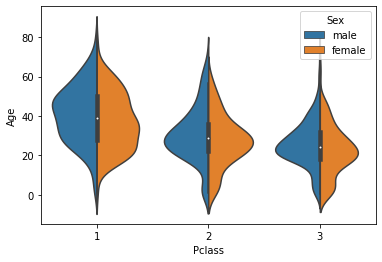

In [25]:
# Plot age for each "Pclass" and "Sex"
sns.violinplot(x=df_data.Pclass.astype('category'), y=df_data.Age, hue=df_data.Sex, split=True)

### Differences in age distribution for different "Pclass" and "Sex" could be observed. 

In [26]:
df_data.Age.describe()

count    1046.000000
mean       29.881138
std        14.413493
min         0.170000
25%        21.000000
50%        28.000000
75%        39.000000
max        80.000000
Name: Age, dtype: float64

In [27]:
# Check median age for each subgroup
print(df_data.groupby(['Pclass','Sex']).agg('median').Age)

print("\nNumber of NAs for Age is (before): ", df_data.Age.isna().sum())

# Fill NaN values with median value for each subgroups
df_data['Age'] = df_data.groupby(['Pclass','Sex']).Age.apply(lambda x: x.fillna(x.median()))

print("\nNumber of NAs for Age is (after): ", df_data.Age.isna().sum())

Pclass  Sex   
1       female    36.0
        male      42.0
2       female    28.0
        male      29.5
3       female    22.0
        male      25.0
Name: Age, dtype: float64

Number of NAs for Age is (before):  263

Number of NAs for Age is (after):  0


#### Cabin/Deck/DistToBoat
Instead of assigning the most frequent value or separate 'missing' designation for missing values in Cabin or Deck feature, we can assign the mean "DistToBoat" for each "Pclass" since we know for each passenger class, how many rooms are allocated on each deck.  

| DECK | HeightToBoat (m) | FIRST CLASS | SECOND CLASS | THIRD CLASS |
| --- | --- | --- | --- | --- |
| T | 0 | 7 | 0 | 0 |
| A | 2.8956 | 42 | 0 | 0 |
| B | 5.6388 | 123 | 0 | 0 |
| C | 8.382 | 310 | 0 | 0 |
| D | 11.5824 | 117 | 118 | 50 |
| E | 14.3256 | 97 | 226 | 260 |
| F | 16.9164 | 0 | 218 | 466 |
| G | 19.3548 | 0 | 112 | 250 |
| **TOTAL** |  | **689** | **674** | **1026** |

In [28]:
meanDistToBoat = {'1':(7*0 + 42*2.8956 + 123*5.6388 + 310*8.382 + 117*11.5824 + 97*14.3256)/(689),
                  '2':(118*11.5824 + 226*14.3256 + 218*16.9164 + 112*19.3548)/(674),
                  '3':(50*11.5824 + 260*14.3256 + 466*16.9164 + 250*19.3548)/(1026)}
meanDistToBoat

{'1': 8.93807198838897, '2': 15.519023145400592, '3': 16.594072514619885}

In [29]:
df_data['DistToBoat'] = df_data.apply(lambda x: meanDistToBoat[str(x.Pclass)] if pd.isna(x.DistToBoat) else x.DistToBoat, axis=1)

#### Embarked
"Embarked" feature tells us which of the 3 ports (C = Cherbourg; Q = Queenstown; S = Southamptom) the passenger boarded the Titanic. There are two missing values for this feature.  
We could fill it in with the most frequent value (S) or better yet, we could look where people with the same surname boarded the ship. 

In [30]:
# Look for the passengers with missing "Embarked" feature

# df_data[df_data.Embarked.isnull()]
# df_data[df_data.Surname=='Icard']
# df_data[df_data.Surname=='Stone']
df_data[df_data.Ticket=='113572']

### Interestingly, both have the same ticket number, boarded the ship alone.

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Surname,SurnameCount,Deck,DistToBoat,FamilySize
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572,Miss,Icard,1,B,5.6388,1
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572,Mrs,Stone,1,B,5.6388,1


In [31]:
# Since we cannot find anyone related to the two passengers (except each other), fill the missing value with the mode. 
modeEmbarked = df_data['Embarked'].mode()[0]
df_data['Embarked'] = df_data['Embarked'].replace(np.nan, modeEmbarked)

#### Fare
There is one missing value for "Fare". We can simply fill this in with the mean fare from the same "Pclass" and "Embarked" group. 

In [32]:
df_data[df_data.Fare.isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Surname,SurnameCount,Deck,DistToBoat,FamilySize
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701,Mr,Storey,1,NaN,16.594073,1


In [33]:
df_data.groupby(['Pclass','Embarked']).agg('mean').Fare

Pclass  Embarked
1       C           106.845330
        Q            90.000000
        S            72.235825
2       C            23.300593
        Q            11.735114
        S            21.206921
3       C            11.021624
        Q            10.390820
        S            14.435422
Name: Fare, dtype: float64

In [34]:
df_data['Fare'] = df_data['Fare'].fillna(14.435422)

<div style='color: white; display: fill; 
    border-radius: 8px; background-color: #ffc967;
    font-size: 100%; letter-spacing:0.5px'> 
    <p style='padding: 8px; color: black;'> 
        <b>2.3 &nbsp; Split data</b>
    </p>
</div> 
Since we merged training and validation data in the beginning, they will be split back for modeling. 

In [35]:
df_train = df_data[df_data.Survived.notna()]
df_test = df_data[df_data.Survived.isna()]

## <b> 3 <span style='color:#90ee90'> | </span> Modeling</b>

In [36]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier

<div style='color: white; display: fill; 
    border-radius: 8px; background-color: #90ee90;
    font-size: 100%; letter-spacing:0.5px'> 
    <p style='padding: 8px; color: black;'> 
        <b>3.1 &nbsp; Feature selection & Encoding</b>
    </p>
</div> 

In [37]:
df_train.head(2)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Surname,SurnameCount,Deck,DistToBoat,FamilySize
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr,Braund,2,NaN,16.594073,2
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs,Cumings,2,C,8.382000,2


In [38]:
# Train set
X_train = df_train[['Age', 'Embarked','Pclass','Sex','Title','SurnameCount','DistToBoat','FamilySize']]
X_train = pd.get_dummies(X_train)
Y_train = df_train['Survived'].astype('int64')

# Test set
X_test = df_test[['Age', 'Embarked','Pclass','Sex','Title','SurnameCount','DistToBoat','FamilySize']]
X_test = pd.get_dummies(X_test)

<div style='color: white; display: fill; 
    border-radius: 8px; background-color: #90ee90;
    font-size: 100%; letter-spacing:0.5px'> 
    <p style='padding: 8px; color: black;'> 
        <b>3.2 &nbsp; K-fold cross-validation</b>
    </p>
</div> 

In [39]:
# Prepare to split the training set into 10 folds
kfold = StratifiedKFold(n_splits=10)

#### Random Forest Classifier
Mean cross-validation accuracy: 0.8283

In [40]:
RFC = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=7)
RFC_cvs = cross_val_score(RFC, X=X_train, y=Y_train, scoring='accuracy', cv=kfold, n_jobs=-1)

In [41]:
print(RFC_cvs)
RFC_cvs.mean()

[0.81111111 0.85393258 0.76404494 0.87640449 0.85393258 0.80898876
 0.82022472 0.7752809  0.86516854 0.85393258]


0.8283021223470662

#### Extremely Randomized Trees Classifier
Mean cross-validation accuracy: 0.8249

In [42]:
ETC = ExtraTreesClassifier(n_estimators=100, max_depth=5, random_state=7)
ETC_cvs = cross_val_score(ETC, X=X_train, y=Y_train, scoring='accuracy', cv=kfold, n_jobs=-1)

In [43]:
print(ETC_cvs)
ETC_cvs.mean()

[0.81111111 0.82022472 0.7752809  0.86516854 0.87640449 0.80898876
 0.83146067 0.76404494 0.84269663 0.85393258]


0.8249313358302123

#### AdaBoost
Mean cross-validation accuracy: 0.8271

In [44]:
ABC = AdaBoostClassifier(n_estimators=100, random_state=7)
ABC_cvs = cross_val_score(ABC, X=X_train, y=Y_train, scoring='accuracy', cv=kfold, n_jobs=-1)

In [45]:
print(ABC_cvs)
ABC_cvs.mean()

[0.85555556 0.83146067 0.80898876 0.83146067 0.80898876 0.82022472
 0.83146067 0.82022472 0.86516854 0.79775281]


0.8271285892634207

#### Gradient Boosting Classifier
Mean cross-validation accuracy: 0.8204

In [46]:
GBC = GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=7)
GBC_cvs = cross_val_score(GBC, X=X_train, y=Y_train, scoring='accuracy', cv=kfold, n_jobs=-1)

In [47]:
print(GBC_cvs)
GBC_cvs.mean()

[0.8        0.83146067 0.76404494 0.83146067 0.83146067 0.7752809
 0.84269663 0.83146067 0.88764045 0.80898876]


0.8204494382022471

<div style='color: white; display: fill; 
    border-radius: 8px; background-color: #90ee90;
    font-size: 100%; letter-spacing:0.5px'> 
    <p style='padding: 8px; color: black;'> 
        <b>3.5 &nbsp; Random hyperparameter grid search</b>
    </p>
</div> 

[(source)](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74)

In [48]:
def RandomGridSearch(model, grid, x, y, folds=3):
    fold = StratifiedKFold(n_splits=folds)
    # Do a random hyperparameter grid search
    random_model = RandomizedSearchCV(estimator=model, 
                                    param_distributions=grid, 
                                    n_iter=100, cv=fold, verbose=1,
                                    n_jobs=-1)
    random_model.fit(x, y)
    print('Best parameters: \n', random_model.best_params_)
    print('Best estimator: \n', random_model.best_estimator_)
    print('Best score: \n', random_model.best_score_)
    print('CV results: ')
    print('min_score: ', min(random_model.cv_results_['mean_test_score']))
    print('max_score: ', max(random_model.cv_results_['mean_test_score']))
    return random_model

#### Gradient Boosting Classifier
Maximum Public Score Achieved: 0.76794

In [49]:
# Loss function to be optimized: {'deviance','exponential'}
loss = ['deviance']

# Number of boosting stages to perform
n_estimators = [100,300,600,900]

# Shrinks contribution of each tree - trade-off with n_estimators
learning_rate = [0.01, 0.05, 0.1]

# limits the number of nodes in tree
max_depth = [3,4,5,6,7,8]

# Min number of samples required to split an internal node
min_samples_split = [2, 5, 10]

# Min number of samples required to be at a leaf node (smoothing)
min_samples_leaf = [1, 10, 100]

# Number of features to consider when looking for the best split
max_features = [None, 'sqrt']

In [50]:
random_grid = {'loss':loss,
              'n_estimators':n_estimators,
              'learning_rate':learning_rate,
              'max_depth':max_depth,
              'min_samples_split':min_samples_split,
              'min_samples_leaf':min_samples_leaf,
              'max_features':max_features}

In [51]:
# %%time
# GBC = GradientBoostingClassifier(random_state=7)
# GBC_random = RandomGridSearch(GBC, random_grid, X_train, Y_train, folds=10)

In [52]:
# predictions = GBC_random.best_estimator_.predict(X_test)

# output = pd.DataFrame({'PassengerId': df_test.PassengerId, 
#                       'Survived': predictions.astype('int64')})
# output.to_csv('submission.csv', index=False)
# print('Your submission was successfully saved!')

#### Random Forest Classifier


In [53]:
# Number of boosting stages to perform
n_estimators = [100,300,600,900]

# function to measure quality of a split (tree-specific)
criterion = ['gini', 'entropy']

# limits the number of nodes in tree
max_depth = [3, 5, 8, None]

# Min number of samples required to split an internal node
min_samples_split = [2, 5, 10]

# Min number of samples required to be at a leaf node (smoothing)
min_samples_leaf = [1, 10, 100]

# Number of features to consider when looking for the best split
max_features = [None, 'sqrt']

# Whether bootstrap samples are used when building trees
bootstrap = [True, False]

In [54]:
random_grid = {'n_estimators':n_estimators,
              'criterion':criterion,
              'max_depth':max_depth,
              'min_samples_split':min_samples_split,
              'min_samples_leaf':min_samples_leaf,
              'max_features':max_features,
              'bootstrap': bootstrap}

In [55]:
%%time
RFC = RandomForestClassifier(random_state=7)
RFC_random = RandomGridSearch(RFC, random_grid, X_train, Y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.6min finished


Best parameters: 
 {'n_estimators': 900, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 5, 'criterion': 'entropy', 'bootstrap': True}
Best estimator: 
 RandomForestClassifier(criterion='entropy', max_depth=5, max_features=None,
                       min_samples_split=5, n_estimators=900, random_state=7)
Best score: 
 0.8395061728395062
CV results: 
min_score:  0.7789001122334457
max_score:  0.8395061728395062
CPU times: user 3.73 s, sys: 71.9 ms, total: 3.8 s
Wall time: 1min 39s


In [56]:
predictions = RFC_random.best_estimator_.predict(X_test)

output = pd.DataFrame({'PassengerId': df_test.PassengerId, 
                      'Survived': predictions.astype('int64')})
output.to_csv('submission.csv', index=False)
print('Your submission was successfully saved!')

Your submission was successfully saved!


#### Random Forest Classifier (hyperparameters from Alexis Cook)
Maximum Public Score Achieved: 0.78229 (without further optimization)

In [57]:
# RFC = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=7)
# RFC.fit(X_train, Y_train)

# predictions = RFC.predict(X_test)

## <b> 4 <span style='color:#92a1cf'> | </span> Model Interpretation</b>

# ***Work in progress***